In [1]:
import networkx as nx
from tqdm.notebook import tqdm
import re
import itertools

In [2]:
from helpers import get_input

In [3]:
input_text,input_list = get_input()

Retrieved from File marcosh_input_day16.txt


In [4]:
sample_input = """Valve AA has flow rate=0; tunnels lead to valves DD, II, BB
Valve BB has flow rate=13; tunnels lead to valves CC, AA
Valve CC has flow rate=2; tunnels lead to valves DD, BB
Valve DD has flow rate=20; tunnels lead to valves CC, AA, EE
Valve EE has flow rate=3; tunnels lead to valves FF, DD
Valve FF has flow rate=0; tunnels lead to valves EE, GG
Valve GG has flow rate=0; tunnels lead to valves FF, HH
Valve HH has flow rate=22; tunnel leads to valve GG
Valve II has flow rate=0; tunnels lead to valves AA, JJ
Valve JJ has flow rate=21; tunnel leads to valve II""".split('\n')

In [5]:
def make_graph(sample_input):
    valves = [re.findall(r"[A-Z]{2}",x) for x in sample_input]
    flow_rates = [int(re.findall(r"\d+",x)[0]) for x in sample_input]
    flow_rate_dict = {key:val for key,val in zip([x[0] for x in valves],flow_rates) }
    G = nx.Graph()
    for i, line in enumerate(valves.copy()):
        start = line.pop(0)
        elist = ([(start,end) for end in line ])
        G.add_edges_from(elist)
    print(flow_rate_dict)
    for node in G:
        G.nodes[node]['flow_rate'] = flow_rate_dict[node]
    return G

In [6]:
def make_distance_dict(G):
    node_list = [x for x in G.nodes if G.nodes[x]['flow_rate'] > 0] + ['AA']
    paths = list(itertools.permutations(node_list,2))
    distance_dict = {f"{source}_{target}": nx.shortest_path_length(G,source=source,target=target) for source,target in paths}
    return distance_dict, node_list

In [7]:
def get_potential_flow(flow,distance,t_remaining):
    flow_time = t_remaining - distance - 1 #time to open and time to travel
    return flow*flow_time 

In [8]:
def get_potential_flow_node_pair(source,target,t_remaining):
    distance = distance_dict.get(f"{source}_{target}",0)
    flow = G.nodes[target]['flow_rate']
    return get_potential_flow(flow,distance,t_remaining),distance

In [9]:
def compute_flow_for_path(path):
    start = 'AA'
    total_flow = 0
    t = 30
    path_list = list(path)

    while path_list:
        
        target = path_list.pop(0)
        flow,distance = get_potential_flow_node_pair(start,target,t)

        t = t-distance-1
        if t <= 0:
         #   print('broke early')
            break
        total_flow += flow
        start = target

        
    return total_flow,path

In [55]:
def get_path_total_cost(path,start='AA',existing_cost=0):
    path = [start] + list(path)
    total_cost = len(path) + existing_cost
    for i in range(len(path)-1):
      #  print(f"{path[i]}_{path[i+1]}")
      #  print(distance_dict.get(f"{path[i]}_{path[i+1]}",0))
        total_cost += distance_dict.get(f"{path[i]}_{path[i+1]}",0)
    return total_cost

def get_path_total_cost2(path,start='AA',existing_cost=0):
    
    total_cost = existing_cost
    total_cost = total_cost + len(path)
    if path[0] != start:
        path = [start] + list(path)
    
    #print(f"turn on cost {total_cost}")

    for i in range(len(path)-1):
        new_cost = distance_dict.get(f"{path[i]}_{path[i+1]}",0)
       # print(f"{path[i]}_{path[i+1]}",new_cost)
        total_cost += new_cost
    return total_cost

## Part 1

{'TZ': 0, 'LH': 0, 'AA': 0, 'GP': 0, 'GN': 0, 'QO': 0, 'JT': 22, 'DF': 0, 'UM': 0, 'KJ': 0, 'UX': 23, 'ZI': 0, 'YF': 0, 'SX': 0, 'KZ': 0, 'IH': 0, 'EL': 0, 'CD': 0, 'OR': 0, 'EK': 19, 'UE': 0, 'WQ': 0, 'XI': 0, 'GO': 0, 'IR': 0, 'WY': 0, 'JH': 0, 'WM': 0, 'OS': 0, 'AE': 0, 'LG': 0, 'IS': 0, 'XU': 0, 'KL': 0, 'LV': 0, 'UI': 0, 'IL': 0, 'XY': 0, 'JF': 15, 'UK': 18, 'CA': 13, 'BL': 0, 'GW': 16, 'CQ': 0, 'HK': 0, 'BO': 4, 'TU': 11, 'AZ': 0, 'FP': 5, 'LE': 14, 'IE': 0, 'NZ': 0, 'DM': 3, 'YH': 21, 'BK': 0, 'LK': 0, 'AR': 20, 'ZJ': 9, 'FR': 0}


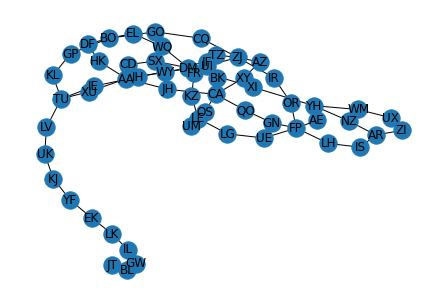

In [11]:
G = make_graph(input_list)
nx.draw(G,with_labels=True)

In [12]:
distance_dict,node_list = make_distance_dict(G)
node_list_no_start = [x for x in G.nodes if G.nodes[x]['flow_rate'] > 0] 
all_paths = itertools.permutations(node_list_no_start,8)


I deleted my orig Part 1 accidentally but I was looping through the abov all_paths (250mil)
and it took 3-4 minutes, it was this:

```python
max(compute_flow_for_path(x) for x in tqdm(all_paths))
```

I got lucky that it happened to be exactly 8 nodes travelled.

### Part 1 a smarter way

In [29]:
def get_paths_part1(starting_paths, n=3):
    cost_list_dict = {}
    out = []
    for starting_path, existing_cost in starting_paths:
        nodes_to_remove = set(starting_path)
        start = starting_path[0]
        all_paths = itertools.permutations(
            set(node_list_no_start).difference(nodes_to_remove), n)
        cost_list = [
            (starting_path + list(x), cost) for x in all_paths
            if (cost := (get_path_total_cost2(
                starting_path + list(x), start=start, existing_cost=0))) <= 30
        ]
        out.extend(cost_list)
    return out

all_paths = get_paths_part1([(['AA'], 0)], n=4)  ## star with itertools, then prune and add on paths that aren't too long
more = all_paths
for i in range(4):
    more = get_paths_part1(more,1)
    all_paths.extend(more.copy())


In [30]:
just_paths = [x[0][1:] for x in all_paths] # remove the AA at the start

In [31]:
just_paths = [x for x in just_paths if get_path_total_cost(x)<=30]
len(just_paths)

148318

In [32]:
res = [compute_flow_for_path(x) for x in just_paths]

In [33]:
max(res)

(1720, ['CA', 'JF', 'LE', 'FP', 'YH', 'UX', 'AR', 'DM'])

## Part 2

In [34]:
def compute_flow_for_path2(path):
    start = 'AA'
    total_flow = 0
    t = 26
    path_list = list(path)
    #print(path_list)

    while path_list:
        
        target = path_list.pop(0)
        #print(start,target)

        flow,distance = get_potential_flow_node_pair(start,target,t)
        #print(t,distance,1)
        t = t-distance-1
        if t <= 0:
         #   print('broke early')
            break
        #print(target,flow,distance,t)
        total_flow += flow
        start = target

        
    return total_flow,path

In [67]:
def get_paths(starting_paths, n=3):
    """start with itertools, trim, and keep going"""
    cost_list_dict = {}
    out = []
    for starting_path, existing_cost in starting_paths:
        nodes_to_remove = set(starting_path)
        start = starting_path[0]
        all_paths = itertools.permutations(
            set(node_list_no_start).difference(nodes_to_remove), n)
        cost_list = [
            (starting_path + list(x), cost) for x in all_paths
            if (cost := (get_path_total_cost2(
                starting_path + list(x), start=start, existing_cost=0))) <= 26
        ]
        out.extend(cost_list)
    return out



all_paths = get_paths_part1([(['AA'], 0)], n=4)  ## star with itertools, then prune and add on paths that aren't too long
more = all_paths
for i in range(4):
    more = get_paths_part1(more,1)
    all_paths.extend(more.copy())


#all_paths = out + more + yet_more + even_more + still_more  ##Cleaned this up in part 2

In [68]:
just_paths = [x[0][1:] for x in all_paths]

In [75]:
get_path_total_cost2(all_paths[0][0])

26

In [76]:
len(just_paths) ## hmm, thought this was shorter

148318

In [77]:
out = [compute_flow_for_path2(path) for path in tqdm(just_paths)]  ## get all scores and paths

top = sorted(out,key=lambda x: -x[0])[:1000] ## JUST LOOK AT TOP 1000

top[0]

my_totals = []
for path1,path2 in itertools.combinations(top,2):
    if not (blargh := set(path1[1]).intersection(path2[1])):  #grab pairs that have no overlap
        my_totals.append((path1[0]+path2[0],path1,path2))  #get pair scores


  0%|          | 0/148318 [00:00<?, ?it/s]

(1307, ['TU', 'UK', 'EK', 'GW', 'JT'])

In [78]:
my_totals[0]

(2582,
 (1307, ['TU', 'UK', 'EK', 'GW', 'JT']),
 (1275, ['CA', 'YH', 'UX', 'AR', 'FP', 'LE']))